In [1]:
# Import the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna
from optuna import Trial
import random
import os
from tcn import TCN
from tensorflow.keras.layers import Input, Layer, Dense, Activation, Conv1D, Dropout, LayerNormalization, add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


Cleaning and preprocessing of the source dataset "solar_station_1.xlsx"

In [2]:
# Load the source dataset. This dataset will be used to pre-train a model to capture patterns, trends, and temporal dependencies, which can then be transferred to the target dataset (solar station 5)
source_dataset = pd.read_excel('solar_station_1.xlsx').drop(index=0)

# Convert Excel file to CSV
source_dataset.to_csv('solar_station_1.csv', index=False)

In [3]:
# Display the first few rows of the source dataset
display(source_dataset.head())

,Time(year-month-day h:m:s),Total solar irradiance (W/m2),Direct normal irradiance (W/m2),Global horizontal irradiance (W/m2),Air temperature (°C),Atmosphere (hpa),Relative humidity (%),Power (MW)
1,2019-01-01 00:15:00,0,0,0,-11.8,930.5,39.3,0.0
2,2019-01-01 00:30:00,0,0,0,-11.4,930.5,39.0,0.0
3,2019-01-01 00:45:00,0,0,0,-11.5,930.5,38.0,0.0
4,2019-01-01 01:00:00,0,0,0,-11.5,930.4,38.9,0.0
5,2019-01-01 01:15:00,0,0,0,-11.8,930.1,39.6,0.0


In [4]:
# Check the datatype of each variable
source_dataset.dtypes

Time(year-month-day h:m:s)              object
Total solar irradiance (W/m2)            int64
Direct normal irradiance (W/m2)          int64
Global horizontal irradiance (W/m2)      int64
Air temperature  (°C)                  float64
Atmosphere (hpa)                       float64
Relative humidity (%)                  float64
Power (MW)                             float64
dtype: object

In [5]:
# Check for additional information
source_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70175 entries, 1 to 70175
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Time(year-month-day h:m:s)           70175 non-null  object 
 1   Total solar irradiance (W/m2)        70175 non-null  int64  
 2   Direct normal irradiance (W/m2)      70175 non-null  int64  
 3   Global horizontal irradiance (W/m2)  70175 non-null  int64  
 4   Air temperature  (°C)                70175 non-null  float64
 5   Atmosphere (hpa)                     70175 non-null  float64
 6   Relative humidity (%)                70175 non-null  float64
 7   Power (MW)                           70175 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 4.3+ MB


In [6]:
# Check for missing values in the entire dataset
missing_values = source_dataset.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
Time(year-month-day h:m:s)             0
Total solar irradiance (W/m2)          0
Direct normal irradiance (W/m2)        0
Global horizontal irradiance (W/m2)    0
Air temperature  (°C)                  0
Atmosphere (hpa)                       0
Relative humidity (%)                  0
Power (MW)                             0
dtype: int64


In [7]:
import pandas as pd
import numpy as np

# Identify negative values in all numerical columns and set them to NaN
source_dataset.iloc[:, 1:] = source_dataset.iloc[:, 1:].applymap(lambda x: np.nan if isinstance(x, (int, float)) and x < 0 else x)

# Replace specific incorrect entries with NaN 
invalid_values = ['NA', '--', 0.001, -99]
source_dataset.replace(invalid_values, np.nan, inplace=True)

# Perform upward completion (forward fill)
source_dataset.fillna(method='ffill', inplace=True)

# Perform downward completion (backward fill) on remaining NaNs
source_dataset.fillna(method='bfill', inplace=True)

# Save the processed data after both fill operations
source_dataset.to_csv('source_dataset_filled.csv', index=False)


In [8]:
# Load the processed data with filled missing values
source_dataset= pd.read_csv('source_dataset_filled.csv')

# Display the first few rows to verify
display(source_dataset.head())

,Time(year-month-day h:m:s),Total solar irradiance (W/m2),Direct normal irradiance (W/m2),Global horizontal irradiance (W/m2),Air temperature (°C),Atmosphere (hpa),Relative humidity (%),Power (MW)
0,2019-01-01 00:15:00,0.0,0.0,0.0,0.3,930.5,39.3,0.0
1,2019-01-01 00:30:00,0.0,0.0,0.0,0.3,930.5,39.0,0.0
2,2019-01-01 00:45:00,0.0,0.0,0.0,0.3,930.5,38.0,0.0
3,2019-01-01 01:00:00,0.0,0.0,0.0,0.3,930.4,38.9,0.0
4,2019-01-01 01:15:00,0.0,0.0,0.0,0.3,930.1,39.6,0.0


In [9]:
source_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70175 entries, 0 to 70174
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Time(year-month-day h:m:s)           70175 non-null  object 
 1   Total solar irradiance (W/m2)        70175 non-null  float64
 2   Direct normal irradiance (W/m2)      70175 non-null  float64
 3   Global horizontal irradiance (W/m2)  70175 non-null  float64
 4   Air temperature  (°C)                70175 non-null  float64
 5   Atmosphere (hpa)                     70175 non-null  float64
 6   Relative humidity (%)                70175 non-null  float64
 7   Power (MW)                           70175 non-null  float64
dtypes: float64(7), object(1)
memory usage: 4.3+ MB


In [10]:
# Convert the 'Time' column to datetime format
source_dataset['Time(year-month-day h:m:s)'] = pd.to_datetime(source_dataset['Time(year-month-day h:m:s)'])

# Verify the changes
print(source_dataset.dtypes)

Time(year-month-day h:m:s)             datetime64[ns]
Total solar irradiance (W/m2)                 float64
Direct normal irradiance (W/m2)               float64
Global horizontal irradiance (W/m2)           float64
Air temperature  (°C)                         float64
Atmosphere (hpa)                              float64
Relative humidity (%)                         float64
Power (MW)                                    float64
dtype: object


In [11]:
# Clean column names
source_dataset.columns = source_dataset.columns.str.replace(r'\(.*\)', '', regex=True).str.strip()
source_dataset.columns = source_dataset.columns.str.replace(' ', '_')  # Replace empty spaces with underscores
source_dataset.columns = source_dataset.columns.str.lower()  # Convert uppercase letters to lowercase

# Display the cleaned column names
display(source_dataset.columns)

Index(['time', 'total_solar_irradiance', 'direct_normal_irradiance',
       'global_horizontal_irradiance', 'air_temperature', 'atmosphere',
       'relative_humidity', 'power'],
      dtype='object')

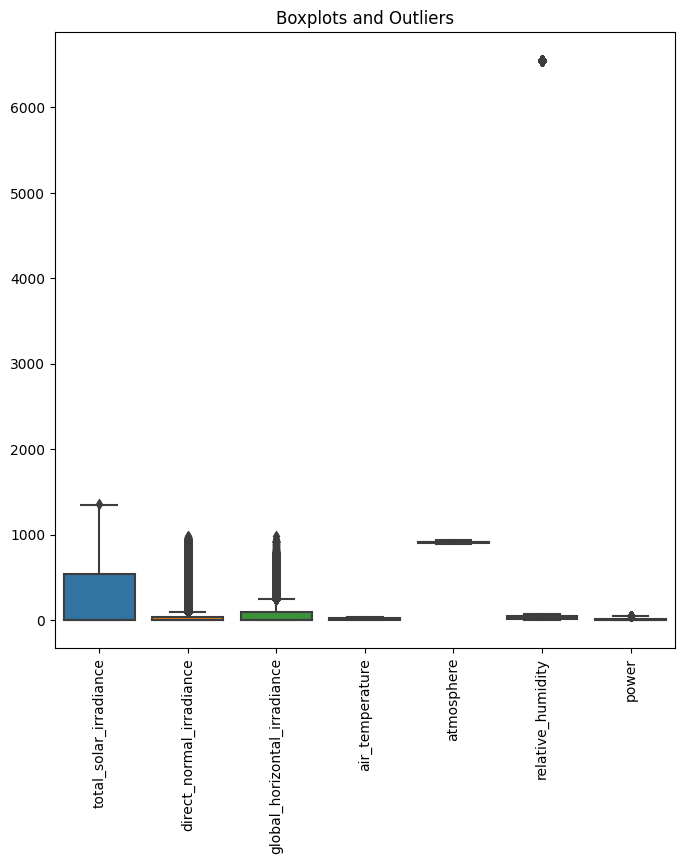

In [12]:
# Check for outliers using the boxplot
plt.figure(figsize=(8, 8))
sns.boxplot(data=source_dataset[['total_solar_irradiance',
                         'direct_normal_irradiance',
                         'global_horizontal_irradiance',
                         'air_temperature',
                         'atmosphere',
                         'relative_humidity',
                         'power']])
plt.xticks(rotation=90)
plt.title('Boxplots and Outliers')

# Save the boxplot as an image file
plt.savefig("boxplots_and_outliers.png", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()


In [13]:
import pandas as pd

# Define the columns to check for outliers
columns_to_check = ['total_solar_irradiance', 'direct_normal_irradiance', 
                    'global_horizontal_irradiance', 'air_temperature', 
                    'atmosphere', 'relative_humidity', 'power']

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for each column and identify outliers
outliers_mask = {}

for column in columns_to_check:
    Q1 = source_dataset[column].quantile(0.25)
    Q3 = source_dataset[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier bounds using 1.5 * IQR rule
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers for each column (values below lower bound or above upper bound)
    outliers = (source_dataset[column] < lower_bound) | (source_dataset[column] > upper_bound)
    outliers_mask[column] = outliers

    # Count how many outliers in each column
    print(f"Outliers in '{column}' before removal: {outliers.sum()}")

# Apply outlier removal (remove rows that have outliers in any of the columns)
source_dataset_cleaned = source_dataset[~(outliers_mask['total_solar_irradiance'] |
                            outliers_mask['direct_normal_irradiance'] |
                            outliers_mask['global_horizontal_irradiance'] |
                            outliers_mask['air_temperature'] |
                            outliers_mask['atmosphere'] |
                            outliers_mask['relative_humidity'] |
                            outliers_mask['power'])]

# Show the shape of the dataset before and after removing outliers
print(f"Original dataset shape: {source_dataset.shape}")
print(f"Dataset shape after removing outliers: {source_dataset_cleaned.shape}")

# Check how many values remain in each column after removing outliers
print("Remaining values in each column after removing outliers:")
print(source_dataset_cleaned[columns_to_check].count())

Outliers in 'total_solar_irradiance' before removal: 1
Outliers in 'direct_normal_irradiance' before removal: 14717
Outliers in 'global_horizontal_irradiance' before removal: 4837
Outliers in 'air_temperature' before removal: 0
Outliers in 'atmosphere' before removal: 0
Outliers in 'relative_humidity' before removal: 6747
Outliers in 'power' before removal: 44
Original dataset shape: (70175, 8)
Dataset shape after removing outliers: (48241, 8)
Remaining values in each column after removing outliers:
total_solar_irradiance          48241
direct_normal_irradiance        48241
global_horizontal_irradiance    48241
air_temperature                 48241
atmosphere                      48241
relative_humidity               48241
power                           48241
dtype: int64


In [14]:
source_dataset_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48241 entries, 0 to 70174
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   time                          48241 non-null  datetime64[ns]
 1   total_solar_irradiance        48241 non-null  float64       
 2   direct_normal_irradiance      48241 non-null  float64       
 3   global_horizontal_irradiance  48241 non-null  float64       
 4   air_temperature               48241 non-null  float64       
 5   atmosphere                    48241 non-null  float64       
 6   relative_humidity             48241 non-null  float64       
 7   power                         48241 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 3.3 MB


In [15]:
source_dataset_cleaned.head()

,time,total_solar_irradiance,direct_normal_irradiance,global_horizontal_irradiance,air_temperature,atmosphere,relative_humidity,power
0,2019-01-01 00:15:00,0.0,0.0,0.0,0.3,930.5,39.3,0.0
1,2019-01-01 00:30:00,0.0,0.0,0.0,0.3,930.5,39.0,0.0
2,2019-01-01 00:45:00,0.0,0.0,0.0,0.3,930.5,38.0,0.0
3,2019-01-01 01:00:00,0.0,0.0,0.0,0.3,930.4,38.9,0.0
4,2019-01-01 01:15:00,0.0,0.0,0.0,0.3,930.1,39.6,0.0


In [16]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# Create a copy of source_dataset
source_dataset = source_dataset_cleaned.copy()

# Replace zeros with NaN in numeric columns 
numeric_columns = source_dataset.select_dtypes(include=[np.number]).columns
source_dataset[numeric_columns] = source_dataset[numeric_columns].replace(0, np.nan)

# Apply linear interpolation to impute NaN values in numeric columns
source_dataset[numeric_columns] = source_dataset[numeric_columns].interpolate(method='linear', limit_direction='both')

# Apply KNN Imputation to handle the remaining 0 values
imputer = KNNImputer(n_neighbors=5)
source_dataset[numeric_columns] = imputer.fit_transform(source_dataset[numeric_columns])

# Verify alignment between 'time' and other features
if source_dataset['time'].nunique() != source_dataset.shape[0]:
    raise ValueError("Mismatch detected: 'time' column and other features are not aligned!")

# Confirm no missing values
missing_values = source_dataset.isnull().sum()
print("Missing values count after imputation:")
print(missing_values)

# Confirm no zero values remain 
zero_values = (source_dataset[numeric_columns] == 0).sum()
print("Zero values count after imputation:")
print(zero_values)

# Display the cleaned DataFrame info
print("Shape of the cleaned DataFrame:", source_dataset.shape)
print(source_dataset.info())

Missing values count after imputation:
time                            0
total_solar_irradiance          0
direct_normal_irradiance        0
global_horizontal_irradiance    0
air_temperature                 0
atmosphere                      0
relative_humidity               0
power                           0
dtype: int64
Zero values count after imputation:
total_solar_irradiance          0
direct_normal_irradiance        0
global_horizontal_irradiance    0
air_temperature                 0
atmosphere                      0
relative_humidity               0
power                           0
dtype: int64
Shape of the cleaned DataFrame: (48241, 8)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 48241 entries, 0 to 70174
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   time                          48241 non-null  datetime64[ns]
 1   total_solar_irradiance        48241

In [17]:
# Make sure time is in datetime format
source_dataset['time'] = pd.to_datetime(source_dataset['time'])

# Set the 'time' column as the index of the DataFrame
source_dataset.set_index('time', inplace=True)

# Filter time between 5:00 and 20:00
source_dataset_filtered = source_dataset.between_time('05:00', '20:00')

# Remove any rows with negative values in numerical columns
numerical_columns = source_dataset_filtered.select_dtypes(include=['number']).columns
source_dataset_filtered = source_dataset_filtered[(source_dataset_filtered[numerical_columns] >= 0).all(axis=1)]


In [18]:
# Check the preprocessed source dataset
source_dataset_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24233 entries, 2019-01-01 05:00:00 to 2020-12-31 20:00:00
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   total_solar_irradiance        24233 non-null  float64
 1   direct_normal_irradiance      24233 non-null  float64
 2   global_horizontal_irradiance  24233 non-null  float64
 3   air_temperature               24233 non-null  float64
 4   atmosphere                    24233 non-null  float64
 5   relative_humidity             24233 non-null  float64
 6   power                         24233 non-null  float64
dtypes: float64(7)
memory usage: 1.5 MB


In [19]:
# Save the source dataset as csv file 
source_dataset_filtered.to_csv('source_dataset_final.csv', index=True)

Pretraining of the source dataset

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna
from optuna import Trial
import random
import os
from tcn import TCN
from tensorflow.keras.layers import Input, Layer, Dense, Activation, Conv1D, Dropout, LayerNormalization, add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models

In [22]:
# Set fixed seed
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [23]:
# Load the source dataset
source_dataset = pd.read_csv(r'source_dataset_final.csv')

# Preprocessing and filtering
source_dataset['time'] = pd.to_datetime(source_dataset['time'], errors='coerce')
source_dataset.set_index('time', inplace=True)
source_dataset = source_dataset.between_time('05:00', '20:00')
numerical_columns = source_dataset.select_dtypes(include=['number']).columns
source_dataset = source_dataset[(source_dataset[numerical_columns] >= 0).all(axis=1)]


In [24]:
# Define time intervals
train_start = '2019-01-01'
train_end = '2020-05-13'
val_start = '2020-05-14'
val_end = '2020-08-08'
test_start = '2020-08-09'
test_end = '2020-12-31'

# Split the data
source_train_df = source_dataset.loc[train_start:train_end]
source_val_df = source_dataset.loc[val_start:val_end]
source_test_df = source_dataset.loc[test_start:test_end]

# Print the shape of the sets
print(f"Training set: {source_train_df.shape}")
print(f"Validation set: {source_val_df.shape}")
print(f"Test set: {source_test_df.shape}")

Training set: (18362, 7)
Validation set: (1886, 7)
Test set: (3985, 7)


In [25]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Select only numeric columns for scaling
numeric_columns = source_train_df.select_dtypes(include=[np.number]).columns

# Fit the scaler on the training set and transform it
train_scaled1 = scaler.fit_transform(source_train_df[numeric_columns])

# Apply scaler.transform on the validation and test sets
val_scaled1 = scaler.transform(source_val_df[numeric_columns])
#test_scaled1 = scaler.transform(test_df[numeric_columns])

# Convert back to DataFrame with the same index and columns
train_scaled1 = pd.DataFrame(train_scaled1, index=source_train_df.index, columns=numeric_columns)
val_scaled1 = pd.DataFrame(val_scaled1, index=source_val_df.index, columns=numeric_columns)
#test_scaled = pd.DataFrame(test_scaled, index=test_df.index, columns=numeric_columns)

In [26]:
def create_sequences(data, target_column, time_steps=24, forecast_horizon=4):
    X, y, timestamps = [], [], []
    # -time_steps - forecast_horizon + 1 to avoid going out of the DataFrame boundaries
    for i in range(len(data) - time_steps - forecast_horizon + 1):
        # Take a "window" of length time_steps
        X.append(data.iloc[i : i + time_steps].values)
        
        # Target values after forecast_horizon steps
        # Instead of just one value, we now predict the next 'forecast_horizon' values
        y.append(data.iloc[i + time_steps : i + time_steps + forecast_horizon][target_column].values)
        
        # Save the timestamp for the last predicted value in the horizon
        timestamps.append(data.index[i + time_steps + forecast_horizon - 1])
        
    return np.array(X), np.array(y), np.array(timestamps)

In [27]:
TIME_STEPS = 24  # Using the last 24 steps (6 hours) as "history"
FORECAST_HORIZON = 4  # Forecasting 4 steps ahead (1 hour)

TARGET_COLUMN = 'power'

# Creating sequences for training data
X_train, y_train, _ = create_sequences(train_scaled1, TARGET_COLUMN,
                                       time_steps=TIME_STEPS,
                                       forecast_horizon=FORECAST_HORIZON)

# Creating sequences for validation data
X_val, y_val, _ = create_sequences(val_scaled1, TARGET_COLUMN,
                                   time_steps=TIME_STEPS,
                                   forecast_horizon=FORECAST_HORIZON)

# Creating sequences for test data
#X_test, y_test, test_timestamps = create_sequences(test_scaled, TARGET_COLUMN,
#                                                   time_steps=TIME_STEPS,
#                                                   forecast_horizon=FORECAST_HORIZON)

# Print the shape 
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
#print(f"Test data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (18335, 24, 7), (18335, 4)
Validation data shape: (1859, 24, 7), (1859, 4)


In [28]:
# Create the residual block 
def residual_block(x, filters, kernel_size, dilation_rate, dropout_rate):
    # Convolution with dilated kernel
    conv1 = layers.Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')(x)
    conv1 = layers.ReLU()(conv1)
    conv1 = layers.Dropout(dropout_rate)(conv1)  # Apply dropout after the first convolution
    conv1 = layers.Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')(conv1)
    
    # Add a residual connection
    residual = layers.Conv1D(filters, 1, padding='causal')(x)  
    x = layers.Add()([conv1, residual])
    x = layers.ReLU()(x)
    
    return x

# Build the TCN architecture
def build_tcn_model(input_shape, n_output, n_blocks=3, filters=64, kernel_size=3, dropout_rate=0.3, dilation_rates=None):
    if dilation_rates is None:
        dilation_rates = [2 ** i for i in range(n_blocks)]  # exponential growth of dilation rates
    
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution layer
    x = layers.Conv1D(filters, kernel_size, padding='causal')(inputs)
    
    # Add multiple residual blocks with specified dilation rates
    for i in range(n_blocks):
        dilation_rate = dilation_rates[i]  # Get the corresponding dilation rate
        x = residual_block(x, filters, kernel_size, dilation_rate, dropout_rate)
    
    # Global average pooling to reduce dimensions
    x = layers.GlobalAveragePooling1D()(x)
    
    # Fully connected layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)  
    outputs = layers.Dense(n_output)(x)  # Output layer for multi-output regression
    
    # Compile the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model



In [32]:
# Objective function for Optuna

def objective(trial):
    # Hyperparameter tuning
    nb_filters = trial.suggest_categorical('nb_filters', [16, 32, 64, 128])  # Number of filters
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)  
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1) 
    kernel_size = trial.suggest_categorical('kernel_size', [2, 3, 5])  
    dilations = trial.suggest_categorical('dilations', [(1, 2, 4), (2, 4, 8)])  # Dilation rates
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256]) 
    
    # Build and compile the TCN model
    model = build_tcn_model(input_shape=X_train.shape[1:], n_output=y_train.shape[1], kernel_size=kernel_size, dilation_rates=dilations, dropout_rate=dropout_rate)
    
    # Set the optimizer with the learning rate and gradient clipping
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_absolute_error')
    
    # Early stopping callback to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    
    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=batch_size, callbacks=[early_stopping], verbose=0)

    # Return the minimum validation loss for optimization
    val_loss = np.min(history.history['val_loss'])
    return val_loss

# Create a study with a specific name
study = optuna.create_study(study_name='TCN1_hyperparameter_optimization', direction='minimize')

# Run the optimization for 10 trials
study.optimize(objective, n_trials=10)

# Print the best hyperparameters found
print("Best hyperparameters:", study.best_params)

[I 2025-01-08 22:09:59,425] A new study created in memory with name: TCN1_hyperparameter_optimization
[I 2025-01-08 22:10:43,151] Trial 0 finished with value: 0.13184334337711334 and parameters: {'nb_filters': 128, 'dropout_rate': 0.27983359163351185, 'learning_rate': 0.08653733993252895, 'kernel_size': 5, 'dilations': (1, 2, 4), 'batch_size': 128}. Best is trial 0 with value: 0.13184334337711334.
[I 2025-01-08 22:11:27,964] Trial 1 finished with value: 0.1323695033788681 and parameters: {'nb_filters': 64, 'dropout_rate': 0.424597221154593, 'learning_rate': 0.07857628616591641, 'kernel_size': 2, 'dilations': (1, 2, 4), 'batch_size': 64}. Best is trial 0 with value: 0.13184334337711334.
[I 2025-01-08 22:12:19,192] Trial 2 finished with value: 0.13196377456188202 and parameters: {'nb_filters': 64, 'dropout_rate': 0.43267136159944497, 'learning_rate': 0.03220604850721403, 'kernel_size': 2, 'dilations': (2, 4, 8), 'batch_size': 64}. Best is trial 0 with value: 0.13184334337711334.
[I 2025-

Best hyperparameters: {'nb_filters': 16, 'dropout_rate': 0.1867054849613525, 'learning_rate': 0.019796959325202475, 'kernel_size': 2, 'dilations': (2, 4, 8), 'batch_size': 256}


In [33]:
# Set fixed seed
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [39]:
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
import tensorflow as tf

# Combine training and validation sets for final retraining
combined_scaled = pd.concat([train_scaled1, val_scaled1])

# Create sequences
X_combined, y_combined, _ = create_sequences(combined_scaled, TARGET_COLUMN, TIME_STEPS)

y_combined = np.reshape(y_combined, (y_combined.shape[0], 4)) 

# Build the model with the best hyperparameters
best_params = study.best_params

# Define the residual block for the TCN
def residual_block(x, filters, kernel_size, dilation_rate, dropout_rate):
    # Convolution with dilated kernel
    conv1 = layers.Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')(x)
    conv1 = layers.ReLU()(conv1)
    conv1 = layers.Dropout(dropout_rate)(conv1)  # Apply dropout after the first convolution
    conv1 = layers.Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')(conv1)
    
    # Add a residual connection
    residual = layers.Conv1D(filters, 1, padding='causal')(x)  
    x = layers.Add()([conv1, residual])
    x = layers.ReLU()(x)
    
    return x

# Define the TCN model with multiple residual blocks
def build_tcn_model(input_shape, n_output, nb_filters, kernel_size, dropout_rate, dilations, n_blocks=3):
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution layer 
    x = layers.Conv1D(nb_filters, kernel_size, padding='causal')(inputs)
    
    # Add multiple residual blocks with increasing dilation rates
    for i in range(n_blocks):
        dilation_rate = dilations[i] if i < len(dilations) else 2 ** i  # Exponentially increasing dilation rate
        x = residual_block(x, nb_filters, kernel_size, dilation_rate, dropout_rate)
    
    # Global average pooling to reduce dimensions
    x = layers.GlobalAveragePooling1D()(x)
    
    # Fully connected layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)  # Apply dropout to the dense layer 
    outputs = layers.Dense(n_output)(x)  # Output layer for multi-output regression
    
    # Compile the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Manually pass the best parameters from the fine-tuning step to build the model
def build_model_with_best_params(input_shape, best_params):
    # Hyperparameters from Optuna
    nb_filters = best_params['nb_filters']
    dropout_rate = best_params['dropout_rate']
    learning_rate = best_params['learning_rate']
    kernel_size = best_params['kernel_size']
    dilations = best_params['dilations']
    batch_size = best_params['batch_size']

    # Set a default value for 'clip_norm' 
    clip_norm = best_params.get('gradient_clipping', 1.0)  # Default 

    # Build and compile the TCN model with the best parameters
    model = build_tcn_model(input_shape=input_shape, 
                            n_output=y_combined.shape[1], 
                            nb_filters=nb_filters,  
                            kernel_size=kernel_size,
                            dilations=dilations,
                            dropout_rate=dropout_rate)

    # Set the optimizer with the learning rate and gradient clipping
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=clip_norm)
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])  
    
    return model

# Build model with the best hyperparameters
model = build_model_with_best_params(input_shape=(X_combined.shape[1], X_combined.shape[2]), best_params=best_params)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model with combined data and early stopping
history = model.fit(X_combined, y_combined, epochs=30, batch_size=best_params['batch_size'], validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Save the pre-trained model weights
model.save_weights('tcn_pretrained.weights.h5')


Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.1706 - mae: 0.1706 - val_loss: 0.0953 - val_mae: 0.0953
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0801 - mae: 0.0801 - val_loss: 0.0832 - val_mae: 0.0832
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0696 - mae: 0.0696 - val_loss: 0.0818 - val_mae: 0.0818
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0674 - mae: 0.0674 - val_loss: 0.0823 - val_mae: 0.0823
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0660 - mae: 0.0660 - val_loss: 0.0795 - val_mae: 0.0795
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0643 - mae: 0.0643 - val_loss: 0.0854 - val_mae: 0.0854
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0631 - mae: 0.0631 - val_loss: 0.0773 - val_mae: 0.0773
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0635 - mae: 0.0635 - val_loss: 0.0764 - val_mae: 0.0764
Epoch 9/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.063

Load the target dataset.

Train the model on the target dataset while fine-tuning the weights. 

In [20]:

# Load the dataset
df = pd.read_csv(r'filtered_data.csv')

# Drop any unnamed columns (columns with 'Unnamed' in their name)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Convert the 'time' column to datetime
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# Set the 'time' column as the index of the DataFrame
df.set_index('time', inplace=True)

# Filter time between 5:00 and 20:00
df = df.between_time('05:00', '20:00')

# Remove any rows with negative values in numerical columns
numerical_columns = df.select_dtypes(include=['number']).columns
df = df[(df[numerical_columns] >= 0).all(axis=1)]

# Check the dimensions
print(f"Cleaned dataset dimensions: {df.shape}")

# Check for missing values in the cleaned dataset
print("Checking for missing values in the cleaned dataset:")
display(df.isnull().sum())

# Save the cleaned dataset to a new CSV file
df.to_csv('cleaned_filtered_data.csv')

Cleaned dataset dimensions: (26404, 7)
Checking for missing values in the cleaned dataset:


total_solar_irradiance          0
direct_normal_irradiance        0
global_horizontal_irradiance    0
air_temperature                 0
atmosphere                      0
relative_humidity               0
power                           0
dtype: int64

In [41]:
# Define time intervals
train_start = '2019-01-01'
train_end = '2020-05-13'
val_start = '2020-05-14'
val_end = '2020-08-08'
test_start = '2020-08-09'
test_end = '2020-12-31'

# Split the data
train_df = df.loc[train_start:train_end]
val_df = df.loc[val_start:val_end]
test_df = df.loc[test_start:test_end]

# Check the shape of each split
print(f"Training set: {train_df.shape}")
print(f"Validation set: {val_df.shape}")
print(f"Test set: {test_df.shape}")

Training set: (19290, 7)
Validation set: (3141, 7)
Test set: (3973, 7)


In [42]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Select only numeric columns for scaling
numeric_columns = train_df.select_dtypes(include=[np.number]).columns

# Fit the scaler on the training set and transform it
train_scaled = scaler.fit_transform(train_df[numeric_columns])

# Apply scaler.transform to validation and test sets
val_scaled = scaler.transform(val_df[numeric_columns])
test_scaled = scaler.transform(test_df[numeric_columns])

# Convert back to DataFrame with the same index and columns
train_scaled = pd.DataFrame(train_scaled, index=train_df.index, columns=numeric_columns)
val_scaled = pd.DataFrame(val_scaled, index=val_df.index, columns=numeric_columns)
test_scaled = pd.DataFrame(test_scaled, index=test_df.index, columns=numeric_columns)

In [43]:
def create_sequences(data, target_column, time_steps=24, forecast_horizon=4):
    X, y, timestamps = [], [], []
    # -time_steps - forecast_horizon + 1 to avoid going out of the DataFrame boundaries
    for i in range(len(data) - time_steps - forecast_horizon + 1):
        # Take a "window" of length time_steps
        X.append(data.iloc[i : i + time_steps].values)
        
        # Target values after forecast_horizon steps
        # Instead of just one value, we now predict the next 'forecast_horizon' values
        y.append(data.iloc[i + time_steps : i + time_steps + forecast_horizon][target_column].values)
        
        # Save the timestamp for the last predicted value in the horizon
        timestamps.append(data.index[i + time_steps + forecast_horizon - 1])
        
    return np.array(X), np.array(y), np.array(timestamps)

In [44]:
TIME_STEPS = 24  # Using the last 24 steps (6 hours) as "history"
FORECAST_HORIZON = 4  # Forecasting 4 steps ahead (1 hour, if each step is 15 minutes)

TARGET_COLUMN = 'power'

# Creating sequences for training data
X_train, y_train, _ = create_sequences(train_scaled, TARGET_COLUMN,
                                       time_steps=TIME_STEPS,
                                       forecast_horizon=FORECAST_HORIZON)

# Creating sequences for validation data
X_val, y_val, _ = create_sequences(val_scaled, TARGET_COLUMN,
                                   time_steps=TIME_STEPS,
                                   forecast_horizon=FORECAST_HORIZON)

# Creating sequences for test data
X_test, y_test, test_timestamps = create_sequences(test_scaled, TARGET_COLUMN,
                                                   time_steps=TIME_STEPS,
                                                   forecast_horizon=FORECAST_HORIZON)

# Print the shape
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")


Training data shape: (19263, 24, 7), (19263, 4)
Validation data shape: (3114, 24, 7), (3114, 4)
Test data shape: (3946, 24, 7), (3946, 4)


In [45]:
# Create the residual block 
def residual_block(x, filters, kernel_size, dilation_rate, dropout_rate):
    # Convolution with dilated kernel
    conv1 = layers.Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')(x)
    conv1 = layers.ReLU()(conv1)
    conv1 = layers.Dropout(dropout_rate)(conv1)  # Apply dropout after the first convolution
    conv1 = layers.Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')(conv1)
    
    # Add a residual connection
    residual = layers.Conv1D(filters, 1, padding='causal')(x)  
    x = layers.Add()([conv1, residual])
    x = layers.ReLU()(x)
    
    return x

# Build the TCN architecture
def build_tcn_model(input_shape, n_output, n_blocks=3, filters=64, kernel_size=3, dropout_rate=0.3, dilation_rates=None):
    if dilation_rates is None:
        dilation_rates = [2 ** i for i in range(n_blocks)]  # Default: exponential growth of dilation rates
    
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution layer
    x = layers.Conv1D(filters, kernel_size, padding='causal')(inputs)
    
    # Add multiple residual blocks with specified dilation rates
    for i in range(n_blocks):
        dilation_rate = dilation_rates[i]  # Get the corresponding dilation rate
        x = residual_block(x, filters, kernel_size, dilation_rate, dropout_rate)
    
    # Global average pooling to reduce dimensions
    x = layers.GlobalAveragePooling1D()(x)
    
    # Fully connected layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)  # Apply dropout to the dense layer 
    outputs = layers.Dense(n_output)(x)  # Output layer for multi-output regression
    
    # Compile the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model



In [46]:
# Objective function for Optuna

def objective(trial):
    # Hyperparameter tuning
    nb_filters = trial.suggest_categorical('nb_filters', [16, 32, 64, 128])  # Number of filters
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)  
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1) 
    kernel_size = trial.suggest_categorical('kernel_size', [2, 3, 5])  
    dilations = trial.suggest_categorical('dilations', [[1, 2, 4], [2, 4, 8]])  # Dilation rates
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256]) 
    
    # Build and compile the TCN model
    model = build_tcn_model(input_shape=X_train.shape[1:], 
                            n_output=y_train.shape[1],  
                            kernel_size=kernel_size,
                            dilation_rates=dilations,  
                            dropout_rate=dropout_rate)
    
    # Set the optimizer with the learning rate and gradient clipping
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_absolute_error')
    
    # Early stopping callback to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    
    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=batch_size, callbacks=[early_stopping], verbose=0)

    # Return the minimum validation loss for optimization
    val_loss = np.min(history.history['val_loss'])
    return val_loss

# Create a study with a specific name
study = optuna.create_study(study_name='TCN2_hyperparameter_optimization', direction='minimize')

# Run the optimization for 10 trials
study.optimize(objective, n_trials=10)

# Print the best hyperparameters found
print("Best hyperparameters:", study.best_params)


[I 2025-01-08 22:28:04,226] A new study created in memory with name: TCN2_hyperparameter_optimization
[I 2025-01-08 22:28:44,678] Trial 0 finished with value: 0.18695852160453796 and parameters: {'nb_filters': 128, 'dropout_rate': 0.3651063654364245, 'learning_rate': 0.09934261032629395, 'kernel_size': 5, 'dilations': [1, 2, 4], 'batch_size': 256}. Best is trial 0 with value: 0.18695852160453796.
[I 2025-01-08 22:29:49,140] Trial 1 finished with value: 0.09838555753231049 and parameters: {'nb_filters': 128, 'dropout_rate': 0.22479769524470777, 'learning_rate': 0.01555949754289794, 'kernel_size': 2, 'dilations': [2, 4, 8], 'batch_size': 64}. Best is trial 1 with value: 0.09838555753231049.
[I 2025-01-08 22:30:26,089] Trial 2 finished with value: 0.18629367649555206 and parameters: {'nb_filters': 32, 'dropout_rate': 0.4027625593846754, 'learning_rate': 0.07196335065826917, 'kernel_size': 3, 'dilations': [1, 2, 4], 'batch_size': 64}. Best is trial 1 with value: 0.09838555753231049.
[I 202

Best hyperparameters: {'nb_filters': 32, 'dropout_rate': 0.2163668416252331, 'learning_rate': 0.003224855820232661, 'kernel_size': 3, 'dilations': [1, 2, 4], 'batch_size': 64}


In [50]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models

# Combine training and validation sets for final retraining
combined_scaled = pd.concat([train_scaled, val_scaled])

# Create sequences
X_combined, y_combined, _ = create_sequences(combined_scaled, TARGET_COLUMN, TIME_STEPS)

y_combined = np.reshape(y_combined, (y_combined.shape[0], 4))  

# Define the residual block for the TCN
def residual_block(x, filters, kernel_size, dilation_rate, dropout_rate):
    # Convolution with dilated kernel
    conv1 = layers.Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')(x)
    conv1 = layers.ReLU()(conv1)
    conv1 = layers.Dropout(dropout_rate)(conv1)  # Apply dropout after the first convolution
    conv1 = layers.Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')(conv1)
    
    # Add a residual connection
    residual = layers.Conv1D(filters, 1, padding='causal')(x)  
    x = layers.Add()([conv1, residual])
    x = layers.ReLU()(x)
    
    return x

# Define the TCN model with multiple residual blocks
def build_tcn_model(input_shape, n_output, nb_filters, kernel_size, dropout_rate, dilations, n_blocks=3):
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution layer 
    x = layers.Conv1D(nb_filters, kernel_size, padding='causal')(inputs)
    
    # Add multiple residual blocks with increasing dilation rates
    for i in range(n_blocks):
        dilation_rate = dilations[i] if i < len(dilations) else 2 ** i  # Exponentially increasing dilation rate
        x = residual_block(x, nb_filters, kernel_size, dilation_rate, dropout_rate)
    
    # Global average pooling to reduce dimensions
    x = layers.GlobalAveragePooling1D()(x)
    
    # Fully connected layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)  # Apply dropout to the dense layer 
    outputs = layers.Dense(n_output)(x)  # Output layer for multi-output regression
    
    # Compile the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Manually pass the best parameters from the fine-tuning step to build the model
def build_model_with_best_params(input_shape, best_params):
    # Hyperparameters from Optuna
    nb_filters = best_params['nb_filters']
    dropout_rate = best_params['dropout_rate']
    learning_rate = best_params['learning_rate']
    kernel_size = best_params['kernel_size']
    dilations = best_params['dilations']
    batch_size = best_params['batch_size']

    # Set a default value for 'clip_norm' 
    clip_norm = best_params.get('gradient_clipping', 1.0)  # Default 

    # Build and compile the TCN model with the best parameters
    model = build_tcn_model(input_shape=input_shape, 
                            n_output=y_combined.shape[1], 
                            nb_filters=nb_filters,  
                            kernel_size=kernel_size,
                            dilations=dilations,
                            dropout_rate=dropout_rate)

    # Set the optimizer with the learning rate and gradient clipping
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=clip_norm)
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])  
    
    return model


# Build model with the best hyperparameters
model = build_model_with_best_params(input_shape=(X_combined.shape[1], X_combined.shape[2]), best_params=best_params)

# Load pretrained weights
model.load_weights('tcn_pretrained.weights.h5', skip_mismatch=True)


# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model with combined data and early stopping
history = model.fit(X_combined, y_combined, epochs=30, batch_size=best_params['batch_size'], validation_split=0.2, callbacks=[early_stopping], verbose=1)



Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.1762 - mae: 0.1762 - val_loss: 0.1439 - val_mae: 0.1439
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1134 - mae: 0.1134 - val_loss: 0.1291 - val_mae: 0.1291
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0992 - mae: 0.0992 - val_loss: 0.1196 - val_mae: 0.1196
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0936 - mae: 0.0936 - val_loss: 0.1432 - val_mae: 0.1432
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1037 - mae: 0.1037 - val_loss: 0.1160 - val_mae: 0.1160
Epoch 6/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0921 - mae: 0.0921 - val_loss: 0.1493 - val_mae: 0.1493
Epoch 7/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1046 - mae: 0.1046 - val_loss: 0.1154 - val_mae: 0.1154
Epoch 8/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0927 - mae: 0.0927 - val_loss: 0.1869 - val_mae: 0.1869
Epoch 9/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.128

In [51]:
model.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 24, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_260 (Conv1D) │ (None, 24, 16)    │        240 │ input_layer_26[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_261 (Conv1D) │ (None, 24, 16)    │        528 │ conv1d_260[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_156 (ReLU)    │ (None, 24, 16)    │          0 │ conv1d_261[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_104         │ (None, 24, 16)    │          0 │ re_lu_156[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_262 (Conv1D) │ (None, 24, 16)    │        528 │ dropout_104[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_263 (Conv1D) │ (None, 24, 16)    │        272 │ conv1d_260[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_78 (Add)        │ (None, 24, 16)    │          0 │ conv1d_262[0][0], │
│                     │                   │            │ conv1d_263[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_157 (ReLU)    │ (None, 24, 16)    │          0 │ add_78[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_264 (Conv1D) │ (None, 24, 16)    │        528 │ re_lu_157[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_158 (ReLU)    │ (None, 24, 16)    │          0 │ conv1d_264[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_105         │ (None, 24, 16)    │          0 │ re_lu_158[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_265 (Conv1D) │ (None, 24, 16)    │        528 │ dropout_105[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_266 (Conv1D) │ (None, 24, 16)    │        272 │ re_lu_157[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_79 (Add)        │ (None, 24, 16)    │          0 │ conv1d_265[0][0], │
│                     │                   │            │ conv1d_266[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_159 (ReLU)    │ (None, 24, 16)    │          0 │ add_79[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_267 (Conv1D) │ (None, 24, 16)    │        528 │ re_lu_159[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_160 (ReLU)    │ (None, 24, 16)    │          0 │ conv1d_267[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_106         │ (None, 24, 16)    │          0 │ re_lu_160[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_268 (Conv1D) │ (None, 24, 16)    │        528 │ dropout_106[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_269 (Conv1D) │ (None, 24, 16)    │        272 │ re_lu_159[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_80 (Add)        │ (None, 24, 16)    │          0 │ conv1d_268[0][0]

 Total params: 20,750 (81.06 KB)

 Trainable params: 6,916 (27.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,834 (54.04 KB)

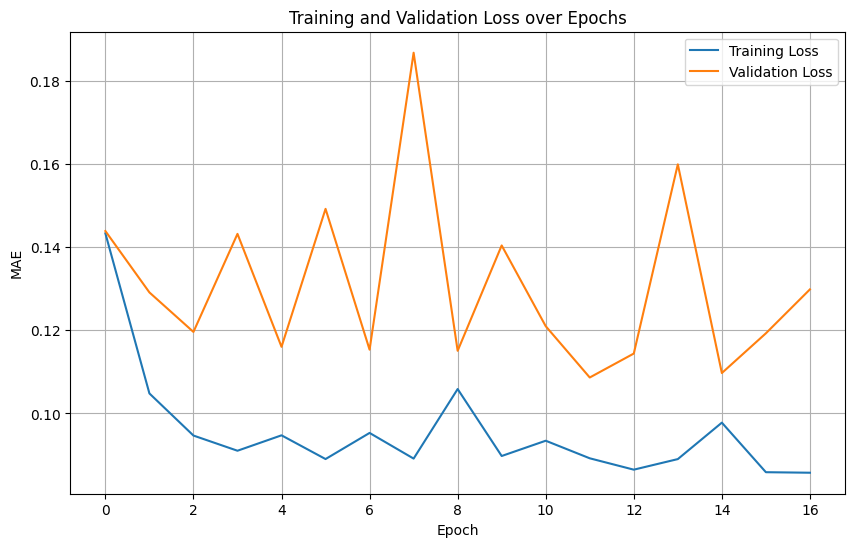

In [52]:
# Plot loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.savefig('TCN2_training_validation_loss.png', dpi=300)
plt.show()

In [53]:
# Inverse scaling for y_pred_train (predicted values on training set)
y_pred_train = model.predict(X_train)

# Only select the predicted target values (1st column for regression target)
y_pred_train_target = y_pred_train[:, 0] 

# Inverse scaling only on the target values (predicted power)
y_pred_train_inv = scaler.inverse_transform(np.column_stack([np.zeros((len(y_pred_train_target), len(numeric_columns) - 1)), y_pred_train_target]))[:, -1]  # Extract the target column only

# Inverse scaling for y_train (actual training set values)
train_inv = scaler.inverse_transform(train_scaled)
train_inv = pd.DataFrame(train_inv, columns=numeric_columns, index=train_scaled.index)
y_train_inv = train_inv[TARGET_COLUMN].values[TIME_STEPS:]  # Skip initial `TIME_STEPS`

# Inverse scaling for y_val (actual values on validation set)
val_inv = scaler.inverse_transform(val_scaled)
val_inv = pd.DataFrame(val_inv, columns=numeric_columns, index=val_scaled.index)
y_val_inv = val_inv[TARGET_COLUMN].values[TIME_STEPS:]  # Skip the first `TIME_STEPS` values

# Inverse scaling for y_pred_val (predicted values on validation set)
y_pred_val = model.predict(X_val)

# Only select the predicted target values
y_pred_val_target = y_pred_val[:, 0] 

# Inverse scaling only on the target values (predicted power)
y_pred_val_inv = scaler.inverse_transform(
    np.column_stack([np.zeros((len(y_pred_val_target), len(numeric_columns) - 1)), y_pred_val_target])
)[:, -1]  # Extract the target column only

# Ensure that train_index and val_index are sliced properly for plotting
train_index = train_inv.index[TIME_STEPS:TIME_STEPS + len(y_pred_train_inv)]
val_index = val_inv.index[TIME_STEPS:TIME_STEPS + len(y_pred_val_inv)]

# Adjust y_train_inv and y_val_inv to match the sliced indices
y_train_inv = y_train_inv[:len(train_index)]
y_val_inv = y_val_inv[:len(val_index)]

# Adjust predicted values to match index lengths
y_pred_train_inv = y_pred_train_inv[:len(train_index)]
y_pred_val_inv = y_pred_val_inv[:len(val_index)]

602/602 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


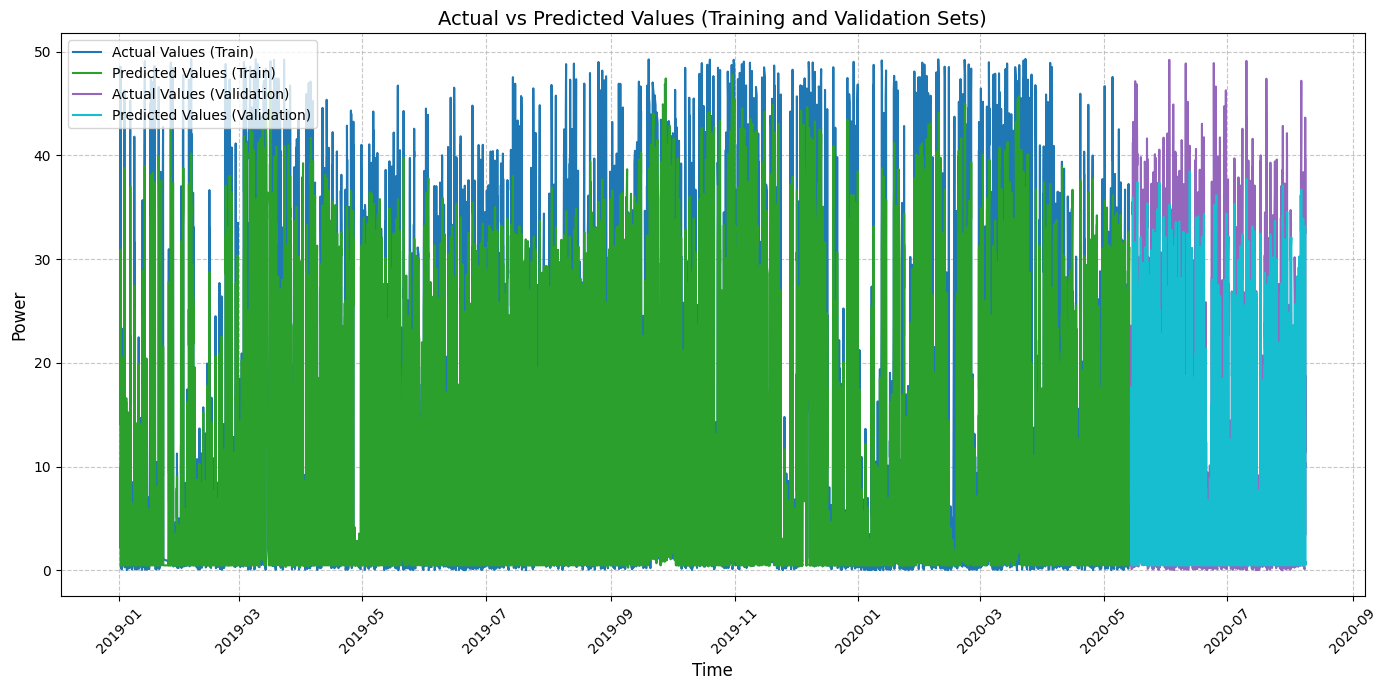

In [54]:
# Plot Actual vs Predicted Values for Training and Validation Sets
plt.figure(figsize=(14, 7))

# Color palette
train_actual_color = '#1f77b4' 
train_predicted_color = '#2ca02c' 
val_actual_color = '#9467bd' 
val_predicted_color = '#17becf'

# Plot for Training Set
plt.plot(train_index, y_train_inv, label='Actual Values (Train)', color=train_actual_color)
plt.plot(train_index, y_pred_train_inv, label='Predicted Values (Train)', color=train_predicted_color)

# Plot for Validation Set
plt.plot(val_index, y_val_inv, label='Actual Values (Validation)', color=val_actual_color)
plt.plot(val_index, y_pred_val_inv, label='Predicted Values (Validation)', color=val_predicted_color)

# Add title and labels
plt.title('Actual vs Predicted Values (Training and Validation Sets)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power', fontsize=12)

# Move the legend to the top-left corner
plt.legend(fontsize=10, loc='upper left')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot with 300 DPI
plt.savefig("actual_vs_predicted_TL_train_val.png", dpi=300)

# Show the plot
plt.show()

In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Training Set Metrics
mae_train = mean_absolute_error(y_train_inv, y_pred_train_inv)
rmse_train = np.sqrt(mean_squared_error(y_train_inv, y_pred_train_inv))
r2_train = r2_score(y_train_inv, y_pred_train_inv)

# Validation Set Metrics
mae_val = mean_absolute_error(y_val_inv, y_pred_val_inv)
rmse_val = np.sqrt(mean_squared_error(y_val_inv, y_pred_val_inv))
r2_val = r2_score(y_val_inv, y_pred_val_inv)

# Print the Results
print("Training Set Metrics:")
print(f"MAE: {mae_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")
print(f"R²: {r2_train:.4f}")

print("\nValidation Set Metrics:")
print(f"MAE: {mae_val:.4f}")
print(f"RMSE: {rmse_val:.4f}")
print(f"R²: {r2_val:.4f}")

Training Set Metrics:
MAE: 3.1822
RMSE: 5.4408
R²: 0.8033

Validation Set Metrics:
MAE: 3.8915
RMSE: 5.7545
R²: 0.7307


In [56]:
# Prediction on test set
y_pred = model.predict(X_test)

# Only select the predicted target values (1st column for regression target)
y_pred_test_target = y_pred[:, 0] 

# Inverse scaling for y_pred_test (predicted values on test set)
y_pred_inv = scaler.inverse_transform(
    np.column_stack([np.zeros((len(y_pred_test_target), len(numeric_columns) - 1)), y_pred_test_target])
)[:, -1]  # Extract the target column only

# Inverse scaling for y_test (actual values on test set)
test_inv = scaler.inverse_transform(test_scaled)
test_inv = pd.DataFrame(test_inv, columns=numeric_columns, index=test_scaled.index)
y_test_inv = test_inv[TARGET_COLUMN].values[TIME_STEPS:]  # Skip the first `TIME_STEPS` values

# Align the test index
test_index = test_inv.index[TIME_STEPS:TIME_STEPS + len(y_pred_inv)]

# Ensure that y_test_inv and y_pred_inv have matching lengths for plotting
y_test_inv = y_test_inv[:len(test_index)]
y_pred_inv = y_pred_inv[:len(test_index)]

124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


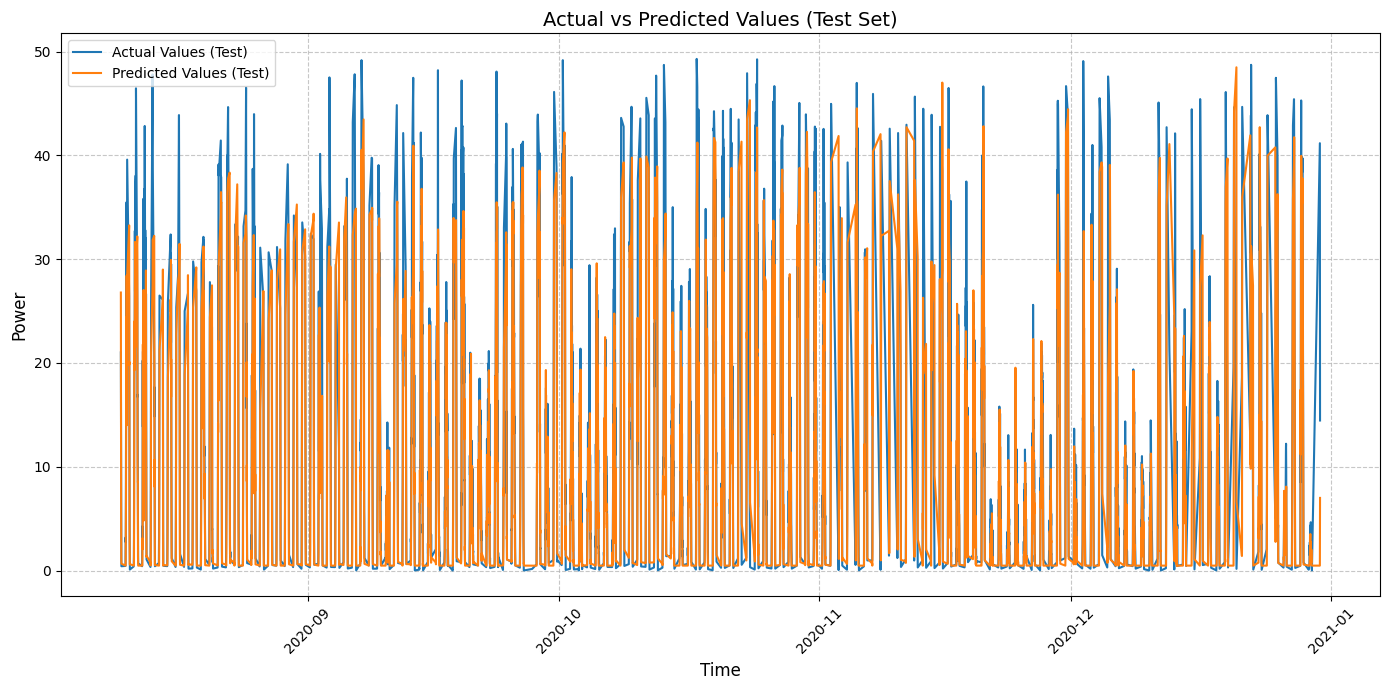

In [57]:
# Plot Actual vs Predicted Values for Test Set
plt.figure(figsize=(14, 7))

# Color palette with orange and blue
test_actual_color = '#1f77b4'  
test_predicted_color = '#ff7f0e'

# Plot for Test Set
plt.plot(test_index, y_test_inv, label='Actual Values (Test)', color=test_actual_color)
plt.plot(test_index, y_pred_inv, label='Predicted Values (Test)', color=test_predicted_color)

# Add title and labels
plt.title('Actual vs Predicted Values (Test Set)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot with 300 DPI
plt.savefig("actual_vs_predicted_test_TL.png", dpi=300)

# Show the plot
plt.show()

In [58]:
from datetime import datetime 

# Calculate metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Save metrics to CSV
metrics = {
    'Timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'MAE': mae,
    'RMSE': rmse,
    'R2': r2
}

metrics_df = pd.DataFrame([metrics])
metrics_file = 'TL_metrics.csv'

if not os.path.isfile(metrics_file):
    metrics_df.to_csv(metrics_file, index=False)
else:
    metrics_df.to_csv(metrics_file, mode='a', header=False, index=False)

print(f"Metrics saved to {metrics_file}")

MAE: 4.20
RMSE: 6.50
R²: 0.7035
Metrics saved to TL_metrics.csv


In [59]:
model.save('Transfer_Learning_model.h5')